# About the project

In this project, I decided to explore different means for neural networks and classical machine learning methods and their capabilities on a binary classification task : classifying whether or not payments 🏷️💲 are fraudulent or not. Many different approaches were tried, from anomaly detection to neural networks and genetic algorithms.

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, neighbors
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(rc = {"figure.figsize":(10, 6)}) #graph size

# Imports and cleaning the data
In the first part the cleanup was done and in the 2nd part I tried different types of improvements to the algorithms. The dataset is connected to credit card fraud data and has the following metrics:
- **distance_from_home** - the distance between the user home location and where the current transaction was initiated, expressed in kilometers
- **distance_from_last_transaction** - the distance between current transaction and last transaction, in kilometers
- **ratio_to_median_purchase_price** - Ratio of transaction price to the median transaction price
- **used_pin_number** - did the transaction require a pin number (renamed to needed_approval)
- **online_order** - if the transaction is online
- repeat_retailer - unused
- used_chip - unused
- **fraud** - Is the transaction fraudulent

This dataset was chosen because it could easily be adapted to the payment system with minimal changes to the payment architecture, and because of the big size of hundreds of thousands of samples which allowed the models to have good accuracy as finance training data is very hard to come by.

The source of the data is https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud and parts of the code is adapted from the book of Fracois Chollet : Deep Learning with Python, as well as my own attempts at optimizing code.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Generate the path to drive dataset, where the kaggle dataset has been previously loaded.

In [ ]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/card-data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/card-data/card_transdata.csv


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/card-data/card_transdata.csv")

## Choosing the features
I decided to rename used pin number to needed approval, so that if a transaction required manual approve because it is large, it is considered the same as if it required a pin number. Additionally, only online payments are supported for our application, so only that data was kept.

In [ ]:
# Selecting and renaming columns
selected_columns = ['distance_from_home', 'distance_from_last_transaction',
                    'ratio_to_median_purchase_price', 'used_pin_number','online_order', 'fraud']

renamed_columns = {
    'used_pin_number': 'needed_approval'
}

# Creating a new DataFrame with the selected and renamed columns
df = df[selected_columns].rename(columns=renamed_columns)

# Filter and keep only the rows where 'online_order' is 1.0
df = df[df['online_order'] == 1.0]
df.drop(columns=['online_order'], inplace=True)

## Some data statistics
Sample data that will be used for training can be seen below. After removing offline payments, over half a million data entries remain.

In [ ]:
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,needed_approval,fraud
2,5.091079,0.805153,0.427715,0.0,0.0
3,2.247564,5.600044,0.362663,0.0,0.0
4,44.190936,0.566486,2.222767,0.0,0.0
6,3.724019,0.956838,0.278465,0.0,0.0
9,8.839047,2.970512,2.361683,0.0,0.0


In [ ]:
df.shape

(650552, 5)

In [ ]:
df.describe().style.background_gradient(cmap = "plasma")

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,needed_approval,fraud
count,650552.000000,650552.000000,650552.000000,650552.000000,650552.000000
mean,26.566435,5.039188,1.823505,0.100544,0.127140
std,65.040899,26.915736,2.796166,0.300724,0.333130
min,0.004874,0.000319,0.004399,0.000000,0.000000
25%,3.877650,0.296006,0.475435,0.000000,0.000000
50%,9.948229,0.995626,0.997604,0.000000,0.000000
75%,25.678092,3.353511,2.095678,0.000000,0.000000
max,10632.723672,11851.104565,266.689692,1.000000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 650552 entries, 2 to 999999
Data columns (total 5 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   distance_from_home              650552 non-null  float64
 1   distance_from_last_transaction  650552 non-null  float64
 2   ratio_to_median_purchase_price  650552 non-null  float64
 3   needed_approval                 650552 non-null  float64
 4   fraud                           650552 non-null  float64
dtypes: float64(5)
memory usage: 29.8 MB


# Data Visualization
Using histograms allows us to make judgements about the data.

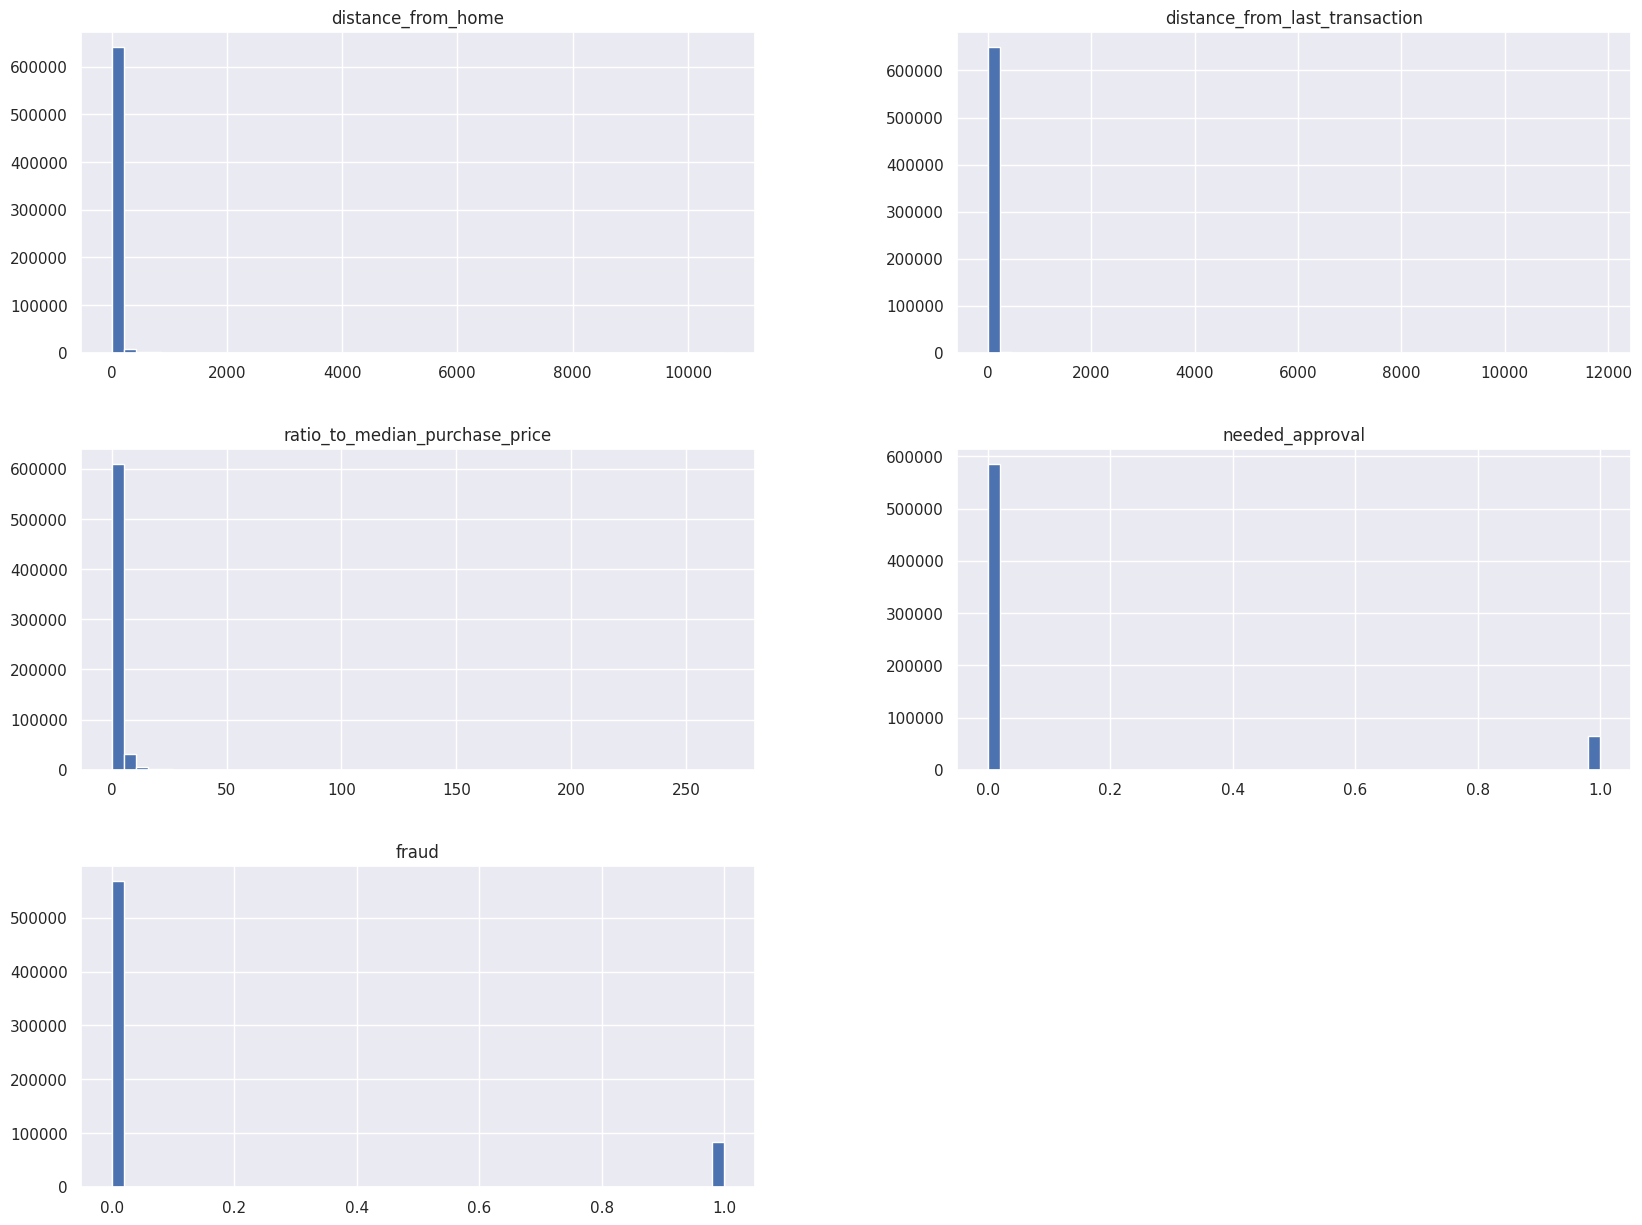

In [ ]:
df.hist(bins =50, figsize=(20,15))
plt.show()

 In order to get a better visualization, remove the outliers this also had the effect of reducing the frauds significantly, so these large values are very likely to be frauds, which gives us more insight than the histogram elements themselves, but just for visualization purposes the data without the outliers has been included.

In [ ]:
percentile_95 = df.quantile(0.95)

# Identify outliers using the 95th percentile and create a boolean mask
outliers_mask = (df > percentile_95)

# Create a new DataFrame containing the outliers
outliers_df = df[outliers_mask.any(axis=1)]

# Remove the outliers from the original DataFrame
cleaned_df = df[~outliers_mask.any(axis=1)]

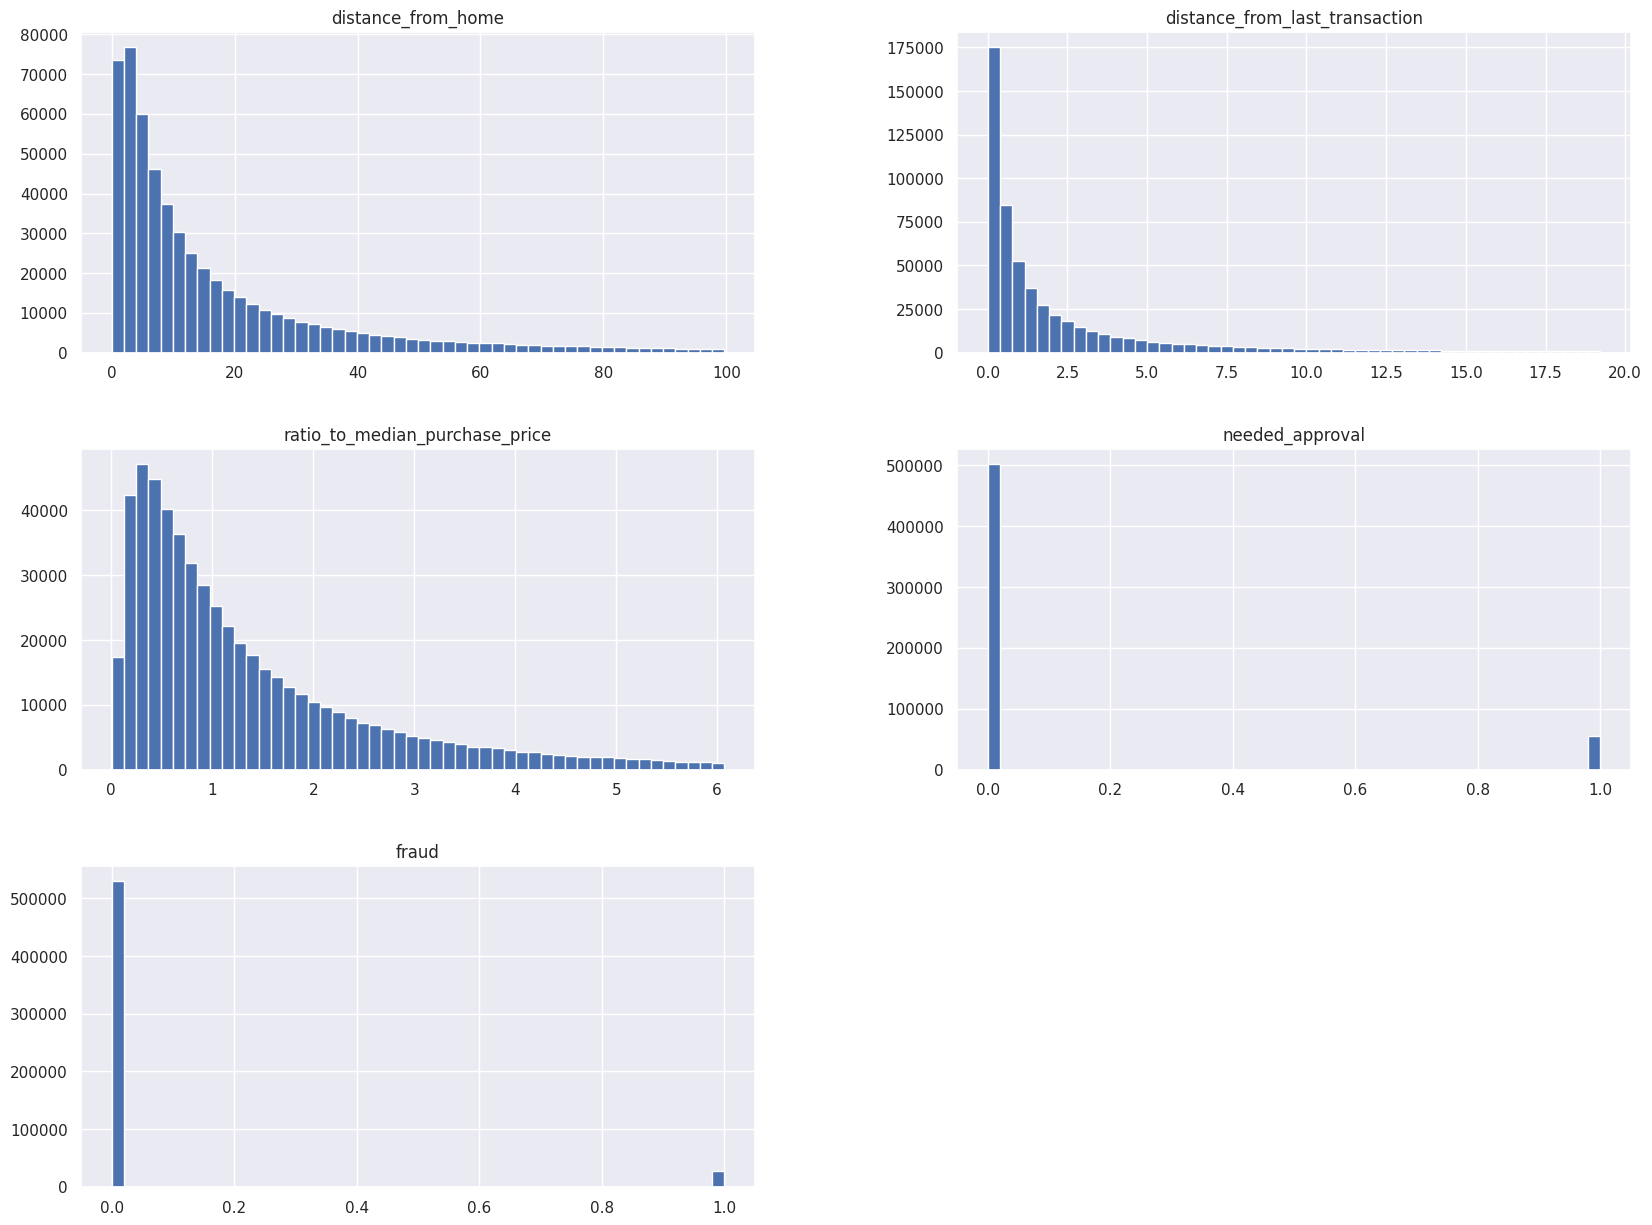

In [ ]:
cleaned_df.hist(bins =50, figsize=(20,15))
plt.show()

## Correlations
The correlation matrix gives us how much of a **linear** relationship we have between features. Thus we see that the median transaction price feature is very strongly correlated with fraud, but also the distances are decent metrics. If the transaction needed approval, it's less likely to be fraud and this is how we interpret the needed approval being negative.

<Axes: >

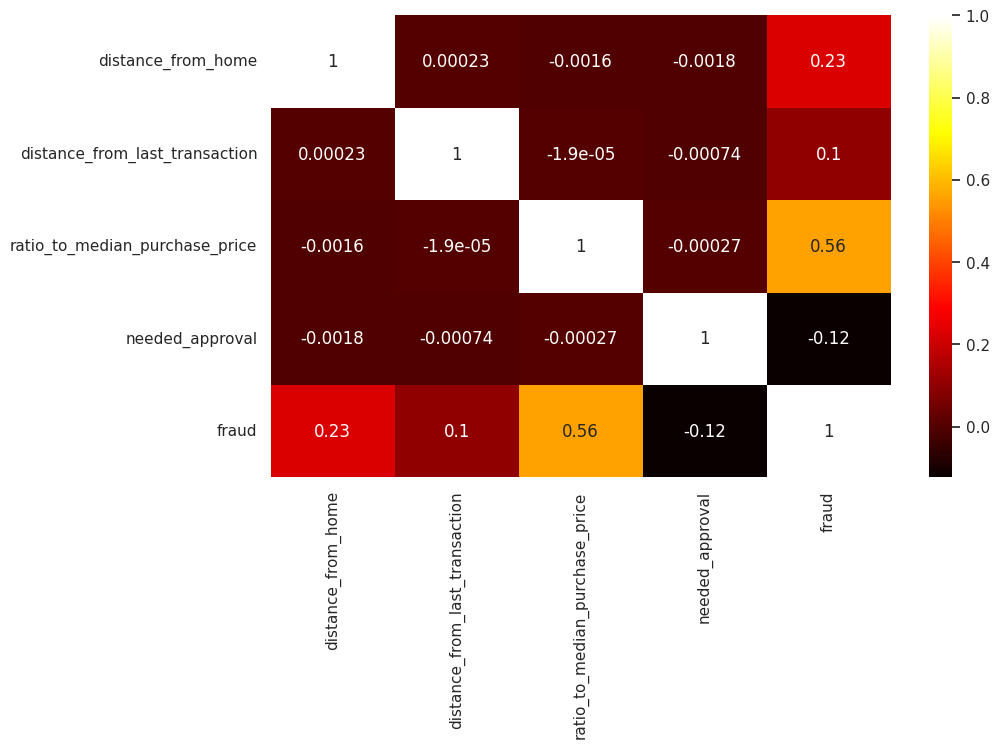

In [ ]:
corr = df.corr()

sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True, cmap = "hot")

# Class distribution : major class imbalance
A common theme around machine learning for fraud detection is that we have a massive class imabalance where we have many transaction which are not fraud and only some which are fraud. This is a big problem, **if only 1% are fraud and ML model predicts not fraud every time we have accuracy of 99% !!!** This is not okay, so other methods for correcting this must be implemented to take care of this massive class imbalance.

fraud
0.0    567841
1.0     82711
dtype: int64

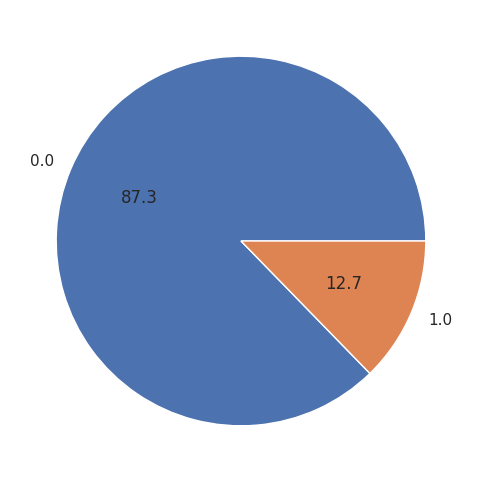

In [ ]:
# Real (class 0.0) meaning non-fraudulent transactions
# Fraud (class 1.0) meaning fraudulent transactions
df.value_counts("fraud").plot.pie(autopct = "%.1f")
df.value_counts("fraud")

In [ ]:
count_1 = df.value_counts("fraud").loc[1.0]
count_1

82711

# Anomaly Detection

I chose to first use anomaly detection, which are classical ML models which try to find these specific "anomalies" in the data.

### Isolation Forest
Isolation Forest is an algorithm for data anomaly detection. Isolation Forest detects anomalies using binary trees. The algorithm has a linear time complexity and a low memory requirement, which works well with high-volume data.

In [ ]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Separate features and labels
X = df.drop(columns=['fraud'])
y = df['fraud']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit an Isolation Forest model
model = IsolationForest(contamination=0.1, random_state=42)  # Contamination represents the expected proportion of anomalies
model.fit(X_train)

# Predict anomalies on the test set
y_pred = model.predict(X_test)

# Convert predictions to binary (0 for normal, 1 for anomaly)
y_pred_binary = (y_pred == -1)

# Evaluate the performance
print(classification_report(y_test, y_pred_binary))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92    113441
         1.0       0.40      0.31      0.35     16670

    accuracy                           0.85    130111
   macro avg       0.65      0.62      0.63    130111
weighted avg       0.84      0.85      0.84    130111



Results: not satisfactory even with varying values for the contamination. More work is needed. Next stop: one class SVM: One-class SVM is an unsupervised algorithm that learns a decision function for novelty detection: classifying new data as similar or different to the training set.

### One class SVM

In [ ]:
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Create a small subset (5%) of the dataset for training and testing
subset_size = int(len(df) * 0.05)
subset_df = df.sample(n=subset_size, random_state=42)

# Separate features and labels
X = subset_df.drop(columns=['fraud'])
y = subset_df['fraud']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit a One-Class SVM model
model = OneClassSVM(nu=0.1)  # The nu parameter controls the proportion of outliers
model.fit(X_train)

# Predict anomalies on the test set
y_pred = model.predict(X_test)

# Convert predictions to binary (1 for normal, -1 for anomaly)
y_pred_binary = (y_pred == 1)

# Evaluate the performance
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

         0.0       0.55      0.06      0.11      5677
         1.0       0.09      0.66      0.16       829

    accuracy                           0.14      6506
   macro avg       0.32      0.36      0.14      6506
weighted avg       0.49      0.14      0.12      6506



Unfortunately, this too had mediocre results.

## LightGBM
The first major success was achieved with the LightGBM regressor, a gradient boosting framework. In order to combat the class imbalance, I adjusted the class weights, giving more importance to fraud samples.

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Separate features and labels
X = df.drop(columns=['fraud'])
y = df['fraud']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit a LightGBM regressor
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'class_weight': {0: 0.2, 1: 1.0},  # Adjust class weights based on class distribution
    'random_state': 42
}

model = lgb.LGBMClassifier(**params)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the performance
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 66041, number of negative: 454400
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 767
[LightGBM] [Info] Number of data points in the train set: 520441, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.420855 -> initscore=-0.319264
[LightGBM] [Info] Start training from score -0.319264
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99    113441
         1.0       0.86      1.00      0.93     16670

    accuracy                           0.98    130111
   macro avg       0.93      0.99      0.96    130111
weighted avg       0.98      0.98      0.98    130111



In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[110825,   2616],
       [    35,  16635]])

### LightGBM results
For the test set data, we had an overall precision of 98% on 130k samples, with very good metrics for the frauds.  Of the frauds, only 35 were missed while over 16k were caught, and 2.6k non-fraudulent transactions were classified as fraudulent out of over 110k, so very good metrics.

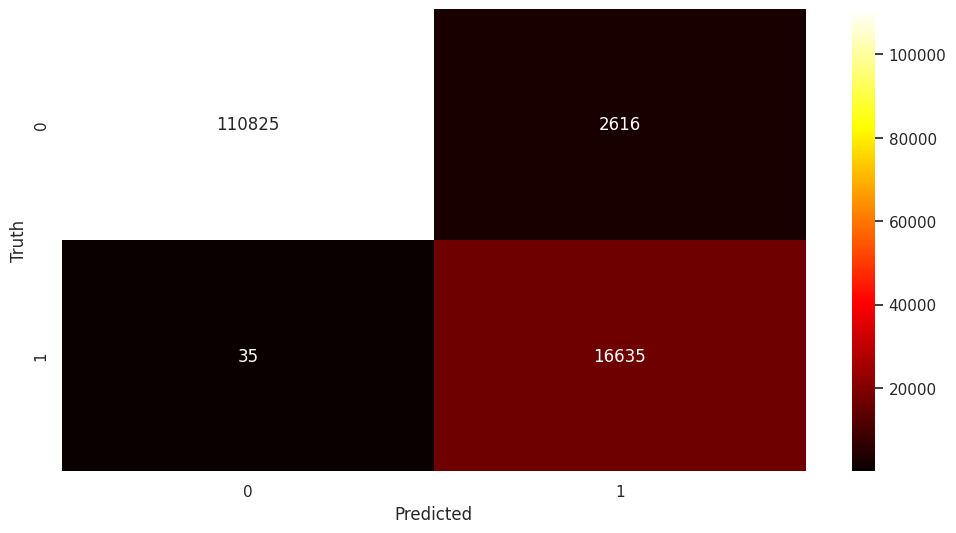

In [ ]:
plt.figure(figsize = (12, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap="hot")  # 'd' format for regular integer notation
plt.xlabel("Predicted")
plt.ylabel("Truth")

plt.show()

### Hyperparameter tunign for lightGBM
I also explored hyperparameter tuning for light gbm in order to see if accuracy can be improved.

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Separate features and labels
X = df.drop(columns=['fraud'])
y = df['fraud']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameter grid for hyperparameter tuning
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.05, 0.075, 0.1],
}

# Create a LightGBM classifier with fixed metrics and class weights
base_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'class_weight': {0: 0.3, 1: 1.0},
    'random_state': 42
}

base_model = lgb.LGBMClassifier(**base_params)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator from the grid search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict on the test set using the best model
y_pred = best_model.predict(X_test)

# Evaluate the performance
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 52832, number of negative: 363520
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 767
[LightGBM] [Info] Number of data points in the train set: 416352, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.420851 -> initscore=-0.319279
[LightGBM] [Info] Start training from score -0.319279
[LightGBM] [Info] Number of positive: 52833, number of negative: 363520
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 767
[LightGBM] [Info] Number of data points in the train set: 416353, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.420856 -> initscore=-0.319

Number of missed frauds was cut from 35 to 29, a decent result if we look at it from a percentage point of view.

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[110834,   2607],
       [    29,  16641]])

In [ ]:
print(grid_search.best_params_)

{'learning_rate': 0.05, 'n_estimators': 100}


Model can be saved for further use

In [ ]:
import pickle


# Get the underlying LightGBM booster object
booster = best_model.booster_

with open('model.pkl', 'wb') as f:
    pickle.dump(booster, f)

# Neural networks
Neural networks (deep learning) are used in a variety of applications, and can achieve very good results if their structure is good, overfitting is kept to a minimum and there is plenty of data.

A basic feed forward neural network can be seen below. The keras API was used, with 2 layers of 32 and 16 neurons respectively. The adam optimizer was used, and the neural network used callbacks to save only the best model on the **validation data**, which means that when the model starts overfitting the data, the best model from this point of view is still saved.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
import pickle

# Separate features and labels
X = df.drop(columns=['fraud']).values
y = df['fraud'].values

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

# Build a feedforward neural network
model = Sequential()
model.add(Dense(units=32, activation='relu', input_dim=X_train_scaled.shape[1]))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define a ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model with validation
class_weight = {0: 0.2, 1: 1.0}  # Higher weight for fraud class
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=128, verbose=1,
                    validation_split=0.2, callbacks=[checkpoint], class_weight=class_weight)

# Load the best model
best_model = load_model('best_model.h5')

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test_scaled)
y_pred_binary = (y_pred > 0.5).astype(int)

Epoch 1/10
3253/3253 [==============================] - 17s 4ms/step - loss: 0.0288 - accuracy: 0.9661 - val_loss: 0.0626 - val_accuracy: 0.9737
Epoch 2/10
3253/3253 [==============================] - 13s 4ms/step - loss: 0.0162 - accuracy: 0.9767 - val_loss: 0.0544 - val_accuracy: 0.9785
Epoch 3/10
3253/3253 [==============================] - 13s 4ms/step - loss: 0.0149 - accuracy: 0.9785 - val_loss: 0.0538 - val_accuracy: 0.9794
Epoch 4/10
3253/3253 [==============================] - 13s 4ms/step - loss: 0.0142 - accuracy: 0.9793 - val_loss: 0.0506 - val_accuracy: 0.9808
Epoch 5/10
3253/3253 [==============================] - 14s 4ms/step - loss: 0.0139 - accuracy: 0.9796 - val_loss: 0.0481 - val_accuracy: 0.9804
Epoch 6/10
3253/3253 [==============================] - 12s 4ms/step - loss: 0.0137 - accuracy: 0.9800 - val_loss: 0.0534 - val_accuracy: 0.9804
Epoch 7/10
3253/3253 [==============================] - 12s 4ms/step - loss: 0.0135 - accuracy: 0.9801 - val_loss: 0.0502 - val_ac

The best model was found at epoch 8, and was the one that was used for the evaluation.

In [ ]:
print(classification_report(y_test, y_pred_binary))
# Get the epoch at which the best model was saved
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
print(f"The best model was saved at epoch {best_epoch}")

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99    113441
         1.0       0.87      1.00      0.93     16670

    accuracy                           0.98    130111
   macro avg       0.94      0.99      0.96    130111
weighted avg       0.98      0.98      0.98    130111

The best model was saved at epoch 8


In [ ]:
cm = confusion_matrix(y_test, y_pred_binary)
cm

array([[110975,   2466],
       [    38,  16632]])

## Neural network metrics
98% accuracy, with similar false positive and false negative numbers compared to the LGBM regressor.

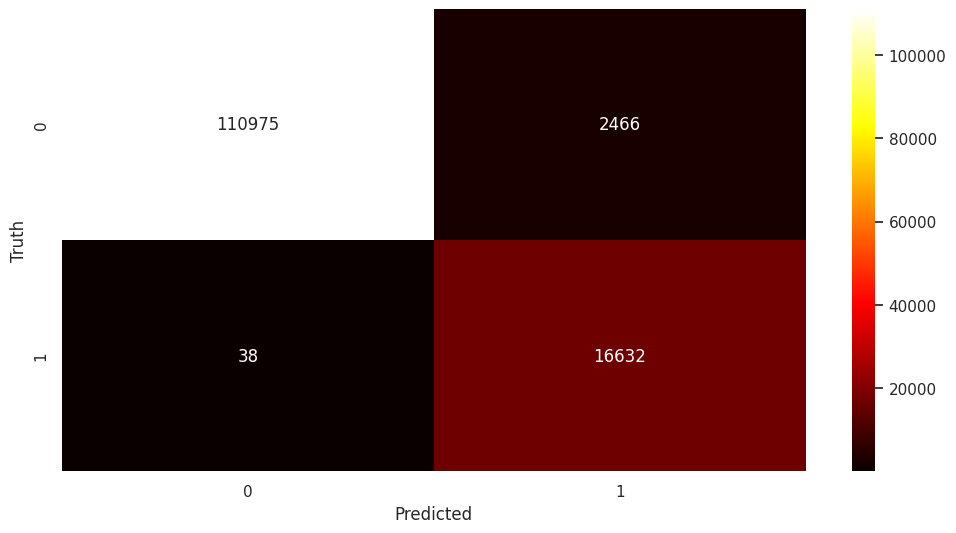

In [ ]:
plt.figure(figsize = (12, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap="hot")  # 'd' format for regular integer notation
plt.xlabel("Predicted")
plt.ylabel("Truth")

plt.show()

# Genetic algorithms 🧬

A genetic algorithm is a biology inspired algorithm that uses techniques from natural selection that repeteadly tests and modifies individuals. hey can be used to explore a wide range of optimization problems, including feature selection, hyperparameter tuning, and model architecture search.

Steps:
- **Objective Function**: Define an objective function that quantifies the quality of a solution. In our case, accuracy.
- **Encoding Solutions**: Represent each solution (individual) in the genetic algorithm using a set of genes (parameters or features). In our case: learning parameter and layer1 and layer2 neurons.
- **Initialization**: Create an initial population of individuals (potential solutions) randomly or using some heuristic.
- **Genetic Operations**: Define genetic operators to evolve the population over generations:
- **Selection**: Choose individuals from the population for reproduction based on their fitness (objective function value).
- **Crossover**: Combine genes of selected individuals to create offspring.
- **Mutation**: Introduce small random changes to the genes of offspring to promote exploration.
- **Fitness Evaluation**: Evaluate the fitness of each individual using the defined objective function. In our case it's just the accuracy as the evalutation.
- **Evolution**: Apply genetic operations to create a new generation of individuals. Repeat this process for a certain number of generations.

Finally, **results** can be analyzed and the best hyperparameters for the model are found. I used the DEAP library to help me with the tuning of the neural network parameters. The best model was kept and evaluated on the test set.

In [ ]:
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
from deap import base, creator, tools, algorithms
import pickle

# Separate features and labels
X = df.drop(columns=['fraud']).values
y = df['fraud'].values

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

with open('scaler_gen.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

class_weight = {0: 0.2, 1: 1.0}

POPULATION_NUMBER = 10 # initially 50
NUMBER_OF_GENERATIONS = 4 # initially 10
NUMBER_OF_EPOCHS = 6 # initially 10

# Define the optimization problem
def objective_function(individual):
    learning_rate = individual[0]
    num_neurons_layer1 = individual[1]
    num_neurons_layer2 = individual[2]

    # Build the neural network model
    model = Sequential()
    model.add(Dense(units=num_neurons_layer1, activation='relu', input_dim=X_train_scaled.shape[1]))
    model.add(Dense(units=num_neurons_layer2, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    # Define the ModelCheckpoint callback to save the best model based on validation accuracy
    checkpoint = ModelCheckpoint('best_model_genetic.h5', monitor='val_accuracy', save_best_only=True, mode='max')

    # Train the model
    history = model.fit(X_train_scaled, y_train, epochs=NUMBER_OF_EPOCHS, batch_size=128, verbose=0,
                        validation_data=(X_val_scaled, y_val), class_weight=class_weight, callbacks=[checkpoint])

    # Load the best model
    best_model = load_model('best_model_genetic.h5')

    # Evaluate the best model on the validation set
    val_pred_prob = best_model.predict(X_val_scaled)
    val_pred = (val_pred_prob > 0.5).astype(int)
    val_accuracy = accuracy_score(y_val, val_pred)

    return val_accuracy,

# Create the DEAP toolbox
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0.0001, 0.1)  # Learning rate range
toolbox.register("attr_int", random.randint, 16, 128)  # Number of neurons in layer 1
toolbox.register("attr_int2", random.randint, 16, 128)  # Number of neurons in layer 2


# Register the individual and population creation functions
toolbox.register("individual", tools.initCycle, creator.Individual,
                (toolbox.attr_float, toolbox.attr_int, toolbox.attr_int2), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Genetic operators
toolbox.register("mate", tools.cxBlend, alpha=0.5)  # Blend crossover
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)  # Gaussian mutation
toolbox.register("select", tools.selTournament, tournsize=3)  # Tournament selection

toolbox.register("evaluate", objective_function)

# Create a population of individuals
population = toolbox.population(n=POPULATION_NUMBER)

# Create the hall of fame to store best individuals
hof = tools.HallOfFame(1)

# Define the statistics to collect during the evolution
stats = tools.Statistics(lambda ind: ind.fitness.values[0])
stats.register("avg", lambda x: sum(x) / len(x))
stats.register("min", min)



# Define the evolutionary algorithm
algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=NUMBER_OF_GENERATIONS,
                    stats=stats, halloffame=hof, verbose=True)

# Get the best individual
best_individual = hof[0]
best_learning_rate, best_units_layer1, best_units_layer2 = best_individual

# Train and evaluate the neural network with the best hyperparameters on the test set
best_model = Sequential()
best_model.add(Dense(units=best_units_layer1, activation='relu', input_dim=X_train_scaled.shape[1]))
best_model.add(Dense(units=best_units_layer2, activation='relu'))
best_model.add(Dense(units=1, activation='sigmoid'))
best_model.compile(optimizer=Adam(learning_rate=best_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# only keep best validation accuracy
checkpoint = ModelCheckpoint('best_model_genetic_final.h5', monitor='val_accuracy', save_best_only=True, mode='max')

best_model.fit(X_train_scaled, y_train, epochs=10, batch_size=128, verbose=1,
               validation_data=(X_val_scaled, y_val), class_weight=class_weight, callbacks=[checkpoint])

best_model= load_model('best_model_genetic_final.h5')

test_pred = best_model.predict(X_test_scaled)
# Convert predicted probabilities to binary predictions using a threshold
test_pred_binary = (test_pred > 0.5).astype(int)
test_accuracy = accuracy_score(y_test, test_pred_binary)

# Print results
print("Best Hyperparameters:")
print(f"Learning Rate: {best_learning_rate}")
print(f"Number of units layer 1: {best_units_layer1}")
print(f"Number of units layer 2: {best_units_layer2}")

print("Test Accuracy with Best Model:", test_accuracy)

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


3050/3050 [==============================] - 4s 1ms/step
gen	nevals	avg     	min     
0  	10    	0.977788	0.972628
3050/3050 [==============================] - 4s 1ms/step
1  	5     	0.979853	0.976748
3050/3050 [==============================] - 4s 1ms/step
2  	5     	0.980411	0.97932 
3050/3050 [==============================] - 4s 1ms/step
3  	8     	0.979879	0.977834
3050/3050 [==============================] - 4s 1ms/step
4  	4     	0.980863	0.980201
Epoch 1/10
3558/3558 [==============================] - 11s 3ms/step - loss: 0.0182 - accuracy: 0.9740 - val_loss: 0.0557 - val_accuracy: 0.9771
Epoch 2/10
3558/3558 [==============================] - 10s 3ms/step - loss: 0.0150 - accuracy: 0.9779 - val_loss: 0.0504 - val_accuracy: 0.9793
Epoch 3/10
3558/3558 [==============================] - 10s 3ms/step - loss: 0.0144 - accuracy: 0.9785 - val_loss: 0.0495 - val_accuracy: 0.9799
Epoch 4/10
3558/3558 [==============================] - 10s 3ms/step - loss: 0.0142 - accuracy: 0.9787 - v

In [ ]:
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.7 MB/s eta 0:00:00


## Genetic algorithm results
The results are decent, but did not significantly improve the accuracy of our model. Perhaps with more tuning, more experimentation and more training time, larger differences would be observed.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
import pickle

X = df.drop(columns=['fraud']).values
y = df['fraud'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

model = Sequential()
model.add(Dense(units=61, activation='relu', input_dim=X_train_scaled.shape[1]))
model.add(Dense(units=112, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))


model.compile(optimizer=Adam(learning_rate=0.003753068828283111), loss='binary_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint('best_model_genetic.h5', monitor='val_accuracy', save_best_only=True, mode='max')


class_weight = {0: 0.2, 1: 1.0}  # Higher weight for fraud class
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=128, verbose=1,
                    validation_split=0.2, callbacks=[checkpoint], class_weight=class_weight)

best_model = load_model('best_model_genetic.h5')

y_pred = best_model.predict(X_test_scaled)
y_pred_binary = (y_pred > 0.5).astype(int)

Epoch 1/10
3253/3253 [==============================] - 13s 3ms/step - loss: 0.0187 - accuracy: 0.9735 - val_loss: 0.0791 - val_accuracy: 0.9688
Epoch 2/10
3253/3253 [==============================] - 9s 3ms/step - loss: 0.0152 - accuracy: 0.9775 - val_loss: 0.0552 - val_accuracy: 0.9778
Epoch 3/10
3253/3253 [==============================] - 9s 3ms/step - loss: 0.0146 - accuracy: 0.9785 - val_loss: 0.0569 - val_accuracy: 0.9765
Epoch 4/10
3253/3253 [==============================] - 9s 3ms/step - loss: 0.0143 - accuracy: 0.9786 - val_loss: 0.0570 - val_accuracy: 0.9774
Epoch 5/10
3253/3253 [==============================] - 9s 3ms/step - loss: 0.0141 - accuracy: 0.9790 - val_loss: 0.0495 - val_accuracy: 0.9802
Epoch 6/10
3253/3253 [==============================] - 9s 3ms/step - loss: 0.0139 - accuracy: 0.9791 - val_loss: 0.0466 - val_accuracy: 0.9807
Epoch 7/10
3253/3253 [==============================] - 9s 3ms/step - loss: 0.0138 - accuracy: 0.9795 - val_loss: 0.0510 - val_accuracy

In [ ]:
print(classification_report(y_test, y_pred_binary))
# Get the epoch at which the best model was saved
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
print(f"The best model was saved at epoch {best_epoch}")

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99    113441
         1.0       0.88      0.99      0.93     16670

    accuracy                           0.98    130111
   macro avg       0.94      0.98      0.96    130111
weighted avg       0.98      0.98      0.98    130111

The best model was saved at epoch 10


In [ ]:
cm = confusion_matrix(y_test, y_pred_binary)
cm

array([[111120,   2321],
       [   180,  16490]])

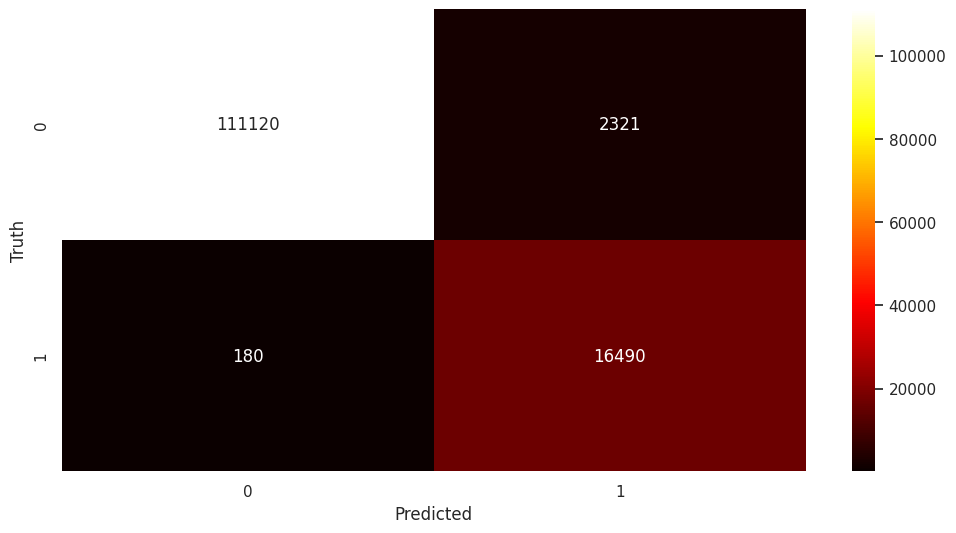

In [ ]:
plt.figure(figsize = (12, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap="hot")  # 'd' format for regular integer notation
plt.xlabel("Predicted")
plt.ylabel("Truth")

plt.show()